This contains the overall code for training a TGCN/GATConv Ternary Stock Movement Prediction model. It uses a non-recurrent approach and contains code meant for ensembling

# Imports

In [ ]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-2.4.0+cu121.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-2.4.0+cu121.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-2.4.0+cu121.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-2.4.0+cu121.html
!pip install torch-geometric
!pip install torch-geometric-temporal
!pip install yfinance
!pip install requests_html
!pip install yahoo_fin

Looking in links: https://pytorch-geometric.com/whl/torch-2.4.0+cu121.html
Looking in links: https://pytorch-geometric.com/whl/torch-2.4.0+cu121.html
Looking in links: https://pytorch-geometric.com/whl/torch-2.4.0+cu121.html
Looking in links: https://pytorch-geometric.com/whl/torch-2.4.0+cu121.html


In [ ]:
!pip install --upgrade torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.4.0+cu121.html

Looking in links: https://data.pyg.org/whl/torch-2.4.0+cu121.html


# Load Data

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import yfinance as yf
import pandas as pd
import numpy as np
import json
import requests
from tqdm import tqdm
from torch_geometric.nn import GATConv
from torch_geometric_temporal.nn.recurrent import TGCN
from yahoo_fin.stock_info import *

# This will error out, open the TGCN file and replace 'from torch_geometric.utils.to_dense_adj import to_dense_adj' with
#                                                     'from torch_geometric.utils import to_dense_adj'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Read and print the stock tickers that make up S&P500
tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0].Symbol.to_list()
tickers = [ticker.replace(".", "-") for ticker in tickers]

In [ ]:
idx2tkr = tickers
tkr2idx = dict([(ticker, i) for i, ticker in enumerate(tickers)])

In [ ]:
for ticker in tqdm(tickers):
  url = f"https://www.dolthub.com/api/v1alpha1/post-no-preference/earnings/master?q=SELECT+*%0AFROM+%60eps_history%60%0AWHERE+%60act_symbol%60+%3D+%22{ticker}%22%0AORDER+BY+%60act_symbol%60+ASC%2C+%60period_end_date%60+ASC%0ALIMIT+1000%3B%0A"
  response = requests.get(url)
  data = response.json()
  with open(f"{ticker}.json", "w") as f:
    json.dump(data, f)

100%|██████████| 503/503 [02:24<00:00,  3.48it/s]


In [ ]:
earnings_hist = {}

In [ ]:
for ticker in tqdm(tickers):
  with open(f"{ticker}.json", "r") as f:
    data = json.load(f)
  if data['query_execution_status'] == "Success":
    earnings_hist[ticker] = data['rows']
  else:
    print(f"Error with {ticker}")

100%|██████████| 503/503 [00:00<00:00, 12350.99it/s]


In [ ]:
historicals = []
for ticker in tqdm(tickers):
  data = yf.Ticker(ticker).history(period="5y").Close.rename(ticker)
  historicals.append(data)

100%|██████████| 503/503 [01:56<00:00,  4.30it/s]


In [ ]:
for i, hist in enumerate(historicals):
  if hist.empty:
    historicals[i] = yf.Ticker(idx2tkr[i]).history(period="max").Close.reindex(historicals[0].index).rename(tickers[i])

<Axes: >

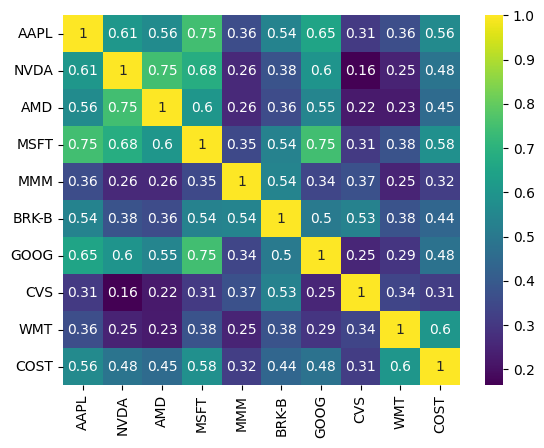

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

price_data = pd.concat(historicals, axis=1)
correlation = price_data.pct_change().corr()

indices = ['AAPL', 'NVDA', 'AMD', 'MSFT', 'MMM', 'BRK-B', 'GOOG', 'CVS', 'WMT', 'COST']
sns.heatmap(correlation[indices].T[indices], annot=True, cmap='viridis')

# Preprocess Data

In [ ]:
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

In [ ]:
def create_correlation_graph(price_data, corr_min, window_size=20):
    """
    Create rolling correlation-based edge weights
    """
    returns = price_data.pct_change()

    # Calculate rolling correlation
    corr_matrices = []
    for i in range(len(returns) - window_size + 1):
        window = returns.iloc[i:i+window_size]
        corr = window.corr()
        corr_matrices.append(corr)

    # Create edges and weights
    edge_index = []
    edge_weights = []

    for corr_matrix in tqdm(corr_matrices):
        edges = np.argwhere(corr_matrix.to_numpy() > CORR_MIN)

        weights = corr_matrix.to_numpy()[edges[:, 0], edges[:, 1]]
        edge_index.append(torch.tensor(edges).t().contiguous())
        edge_weights.append(torch.tensor(weights))

    return edge_index, edge_weights

def prepare_stock_features(symbols, price_data, pos_bound, neg_bound, scaler=None, window_size=20):
    """Prepare stock features with technical indicators"""
    exceeds_all = []
    misses_all = []
    # Calculate features
    features = []
    for symbol in symbols:
        df = pd.DataFrame()
        # Price momentum
        df['returns'] = price_data[symbol].pct_change()
        df['momentum'] = price_data[symbol].pct_change(window_size)
        # Volatility
        df['volatility'] = df['returns'].rolling(window=window_size).std()
        # Moving averages
        df['ma20'] = price_data[symbol].rolling(window=20).mean()
        df['ma50'] = price_data[symbol].rolling(window=50).mean()

        df['tern'] = 0
        df.loc[df['returns'] > pos_bound * df['volatility'], 'tern'] = 1
        df.loc[-df['returns'] > neg_bound * df['volatility'], 'tern'] = -1
        exceeds_all.append(len(df[df.tern == 1]) / len(df))
        misses_all.append(len(df[df.tern == -1]) / len(df))
        features.append(df)

    print("Exceeds Pricing: ", sum(exceeds_all) / len(exceeds_all))
    print("Misses Pricing: ", sum(misses_all) / len(misses_all))

    # Combine features
    combined_features = np.stack([f.fillna(0).values for f in features], axis=1)
    if scaler is None:
      # Scale features
      scaler = StandardScaler()
      scaled_features = scaler.fit_transform(combined_features.reshape(-1, combined_features.shape[-1]))
      scaled_features = scaled_features.reshape(combined_features.shape)
    else:
      scaled_features = scaler.transform(combined_features.reshape(-1, combined_features.shape[-1]))
      scaled_features = scaled_features.reshape(combined_features.shape)
    scaled_features[:, :, -1] = combined_features[:, :, -1]
    return torch.tensor(scaled_features), scaler

In [ ]:
# Split data into test and train
split_date = price_data.index[-126]  # Approximately 126 business days for last 6 months
price_data_train = price_data[price_data.index < split_date]
price_data_test = price_data[price_data.index >= split_date]

In [ ]:
CORR_MIN = 0.25

P_POSITIVE_BOUND = 0.25
P_NEGATIVE_BOUND = 0.7

N_POSITIVE_BOUND = 0.9
N_NEGATIVE_BOUND = 0.2

In [ ]:
print("Preparing positive stock features...")
features_train_pos, scaler_pos = prepare_stock_features(tickers, price_data_train, P_POSITIVE_BOUND, P_NEGATIVE_BOUND)
features_train_pos = features_train_pos.to(torch.float32)

print("Preparing negative stock features...")
features_train_neg, scaler_neg = prepare_stock_features(tickers, price_data_train, N_POSITIVE_BOUND, N_NEGATIVE_BOUND)
features_train_neg = features_train_neg.to(torch.float32)

Preparing positive stock features...
Exceeds Pricing:  0.3968247005171092
Misses Pricing:  0.2074069264904832
Preparing negative stock features...
Exceeds Pricing:  0.1762189440585087
Misses Pricing:  0.38056216978797963


In [ ]:
print("Creating correlation matrices...")
edge_index_train, edge_weights_train = create_correlation_graph(price_data_train, CORR_MIN)

edge_index_train = [ei.to(torch.long) for ei in edge_index_train]
edge_weights_train = [ew.to(torch.float32) for ew in edge_weights_train]

Creating correlation matrices...


100%|██████████| 1114/1114 [00:08<00:00, 125.23it/s]


In [ ]:
features_test_pos, _ = prepare_stock_features(tickers, price_data_test, P_POSITIVE_BOUND, P_NEGATIVE_BOUND, scaler=scaler_pos)
features_test_neg, _ = prepare_stock_features(tickers, price_data_test, N_POSITIVE_BOUND, N_NEGATIVE_BOUND, scaler=scaler_neg)
edge_index_test, edge_weights_test = create_correlation_graph(price_data_test, CORR_MIN)

Exceeds Pricing:  0.35648016661933185
Misses Pricing:  0.15570071633689936
Exceeds Pricing:  0.152182145223895
Misses Pricing:  0.30236044053141464


100%|██████████| 107/107 [00:00<00:00, 211.18it/s]


# Training
This contains the non-recurrent training loop

In [ ]:
class TemporalStockPredictor(nn.Module):
    def __init__(self, node_features, hidden_dim, num_heads=4):
        super(TemporalStockPredictor, self).__init__()

        # Temporal GCN layer
        self.tgcn = TGCN(in_channels=node_features,
                         out_channels=hidden_dim)

        # Graph attention layer for capturing dynamic correlations
        self.gat = GATConv(
            in_channels=hidden_dim,
            out_channels=hidden_dim,
            heads=num_heads,
            concat=True,
            dropout=0.2
        )

        # Prediction layers
        self.fc1 = nn.Linear(hidden_dim * num_heads, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 3)

    def forward(self, x, edge_index, edge_weight):
        # Process temporal features
        h = self.tgcn(x, edge_index)

        # Apply graph attention with edge weights
        h = self.gat(h, edge_index, edge_weight)

        # Make predictions
        h = F.relu(self.fc1(h))
        pred = self.fc2(h)

        return pred

In [ ]:
def train_price_predictor(symbols, price_data, features, edge_index, edge_weights, hidden_dim=64, epochs=100, num_heads = 4):

    # Model parameters
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = TemporalStockPredictor(
        node_features=features.shape[-1],
        hidden_dim=hidden_dim,
        num_heads=num_heads
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss() # Switch to cross entropy

    # Training loop
    model.train()
    for epoch in range(epochs):
        total_loss = 0

        for t in tqdm(range(len(edge_index)-1)):
            optimizer.zero_grad()

            # Get batch data
            x = features[t+19].to(device)
            edge_idx = edge_index[t].to(device)
            edge_w = edge_weights[t].to(device)

            # Forward pass
            y_pred = model(x, edge_idx, edge_w).squeeze()

            # Calculate loss
            y_true = features[t+20, :, 5].to(device).long() + 1 # Next day's ternary prediction
            y_one_hot = torch.nn.functional.one_hot(y_true, 3).to(torch.float64)
            loss = criterion(y_pred, y_one_hot)

            # Backward pass
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(edge_index):.6f}')

    return model

In [ ]:
# Training model that predicts positive examples better
model_pos = train_price_predictor(
    symbols=tickers,
    price_data=price_data,
    features=features_train_pos,
    edge_index=edge_index_train,
    edge_weights=edge_weights_train,
    hidden_dim=64,
    epochs=30,
    num_heads=4
)

100%|██████████| 1113/1113 [00:24<00:00, 45.54it/s]


Epoch 1/30, Loss: 1.053926


100%|██████████| 1113/1113 [00:24<00:00, 44.67it/s]


Epoch 2/30, Loss: 1.061376


100%|██████████| 1113/1113 [00:24<00:00, 46.04it/s]


Epoch 3/30, Loss: 1.060724


100%|██████████| 1113/1113 [00:25<00:00, 44.50it/s]


Epoch 4/30, Loss: 1.050514


100%|██████████| 1113/1113 [00:24<00:00, 46.18it/s]


Epoch 5/30, Loss: 1.049890


100%|██████████| 1113/1113 [00:24<00:00, 45.86it/s]


Epoch 6/30, Loss: 1.048153


100%|██████████| 1113/1113 [00:25<00:00, 44.42it/s]


Epoch 7/30, Loss: 1.044723


100%|██████████| 1113/1113 [00:24<00:00, 45.67it/s]


Epoch 8/30, Loss: 1.044894


100%|██████████| 1113/1113 [00:24<00:00, 45.84it/s]


Epoch 9/30, Loss: 1.043817


100%|██████████| 1113/1113 [00:23<00:00, 46.48it/s]


Epoch 10/30, Loss: 1.044045


100%|██████████| 1113/1113 [00:23<00:00, 46.39it/s]


Epoch 11/30, Loss: 1.043403


100%|██████████| 1113/1113 [00:24<00:00, 46.09it/s]


Epoch 12/30, Loss: 1.042875


100%|██████████| 1113/1113 [00:24<00:00, 45.87it/s]


Epoch 13/30, Loss: 1.043690


100%|██████████| 1113/1113 [00:24<00:00, 45.71it/s]


Epoch 14/30, Loss: 1.043065


100%|██████████| 1113/1113 [00:23<00:00, 46.62it/s]


Epoch 15/30, Loss: 1.043527


100%|██████████| 1113/1113 [00:24<00:00, 46.26it/s]


Epoch 16/30, Loss: 1.042589


100%|██████████| 1113/1113 [00:24<00:00, 46.21it/s]


Epoch 17/30, Loss: 1.041607


100%|██████████| 1113/1113 [00:24<00:00, 45.88it/s]


Epoch 18/30, Loss: 1.040633


100%|██████████| 1113/1113 [00:24<00:00, 45.85it/s]


Epoch 19/30, Loss: 1.041191


100%|██████████| 1113/1113 [00:23<00:00, 46.40it/s]


Epoch 20/30, Loss: 1.040889


100%|██████████| 1113/1113 [00:24<00:00, 46.31it/s]


Epoch 21/30, Loss: 1.040017


100%|██████████| 1113/1113 [00:24<00:00, 45.92it/s]


Epoch 22/30, Loss: 1.039559


100%|██████████| 1113/1113 [00:24<00:00, 45.80it/s]


Epoch 23/30, Loss: 1.039718


100%|██████████| 1113/1113 [00:24<00:00, 45.79it/s]


Epoch 24/30, Loss: 1.039404


100%|██████████| 1113/1113 [00:24<00:00, 46.25it/s]


Epoch 25/30, Loss: 1.039866


100%|██████████| 1113/1113 [00:23<00:00, 46.48it/s]


Epoch 26/30, Loss: 1.039335


100%|██████████| 1113/1113 [00:24<00:00, 46.36it/s]


Epoch 27/30, Loss: 1.038706


100%|██████████| 1113/1113 [00:24<00:00, 46.00it/s]


Epoch 28/30, Loss: 1.038558


100%|██████████| 1113/1113 [00:24<00:00, 45.88it/s]


Epoch 29/30, Loss: 1.038744


100%|██████████| 1113/1113 [00:24<00:00, 46.28it/s]

Epoch 30/30, Loss: 1.038173


In [ ]:
# Training model that predicts negative examples better
model_neg = train_price_predictor(
    symbols=tickers,
    price_data=price_data,
    features=features_train_neg,
    edge_index=edge_index_train,
    edge_weights=edge_weights_train,
    hidden_dim=64,
    epochs=30,
    num_heads=6
)

100%|██████████| 1113/1113 [00:31<00:00, 35.85it/s]


Epoch 1/30, Loss: 1.034741


100%|██████████| 1113/1113 [00:31<00:00, 35.81it/s]


Epoch 2/30, Loss: 1.033158


100%|██████████| 1113/1113 [00:30<00:00, 36.74it/s]


Epoch 3/30, Loss: 1.036313


100%|██████████| 1113/1113 [00:30<00:00, 36.68it/s]


Epoch 4/30, Loss: 1.027655


100%|██████████| 1113/1113 [00:30<00:00, 36.65it/s]


Epoch 5/30, Loss: 1.026492


100%|██████████| 1113/1113 [00:30<00:00, 36.87it/s]


Epoch 6/30, Loss: 1.025328


100%|██████████| 1113/1113 [00:30<00:00, 36.44it/s]


Epoch 7/30, Loss: 1.023780


100%|██████████| 1113/1113 [00:30<00:00, 36.77it/s]


Epoch 8/30, Loss: 1.023024


100%|██████████| 1113/1113 [00:30<00:00, 37.00it/s]


Epoch 9/30, Loss: 1.022938


100%|██████████| 1113/1113 [00:30<00:00, 36.82it/s]


Epoch 10/30, Loss: 1.022132


100%|██████████| 1113/1113 [00:30<00:00, 36.57it/s]


Epoch 11/30, Loss: 1.021861


100%|██████████| 1113/1113 [00:30<00:00, 36.90it/s]


Epoch 12/30, Loss: 1.022333


100%|██████████| 1113/1113 [00:30<00:00, 36.96it/s]


Epoch 13/30, Loss: 1.024069


100%|██████████| 1113/1113 [00:30<00:00, 36.79it/s]


Epoch 14/30, Loss: 1.021841


100%|██████████| 1113/1113 [00:30<00:00, 36.61it/s]


Epoch 15/30, Loss: 1.020738


100%|██████████| 1113/1113 [00:30<00:00, 36.92it/s]


Epoch 16/30, Loss: 1.022740


100%|██████████| 1113/1113 [00:30<00:00, 36.91it/s]


Epoch 17/30, Loss: 1.021361


100%|██████████| 1113/1113 [00:30<00:00, 36.59it/s]


Epoch 18/30, Loss: 1.020376


100%|██████████| 1113/1113 [00:30<00:00, 36.54it/s]


Epoch 19/30, Loss: 1.020178


100%|██████████| 1113/1113 [00:30<00:00, 36.63it/s]


Epoch 20/30, Loss: 1.020608


100%|██████████| 1113/1113 [00:30<00:00, 36.93it/s]


Epoch 21/30, Loss: 1.019868


100%|██████████| 1113/1113 [00:30<00:00, 36.80it/s]


Epoch 22/30, Loss: 1.019696


100%|██████████| 1113/1113 [00:30<00:00, 36.70it/s]


Epoch 23/30, Loss: 1.019132


100%|██████████| 1113/1113 [00:30<00:00, 36.78it/s]


Epoch 24/30, Loss: 1.018884


100%|██████████| 1113/1113 [00:30<00:00, 36.60it/s]


Epoch 25/30, Loss: 1.019106


100%|██████████| 1113/1113 [00:30<00:00, 36.63it/s]


Epoch 26/30, Loss: 1.019909


100%|██████████| 1113/1113 [00:30<00:00, 36.80it/s]


Epoch 27/30, Loss: 1.018347


100%|██████████| 1113/1113 [00:30<00:00, 36.51it/s]


Epoch 28/30, Loss: 1.019382


100%|██████████| 1113/1113 [00:30<00:00, 36.09it/s]


Epoch 29/30, Loss: 1.018733


100%|██████████| 1113/1113 [00:30<00:00, 36.25it/s]

Epoch 30/30, Loss: 1.019188


# Testing
This largely contains failed ensembling attempts

In [ ]:
with torch.no_grad():

    model_pos.eval()

    features_test = features_test_pos.to(torch.float32)
    edge_index_test = [ei.to(torch.long) for ei in edge_index_test]
    edge_weights_test = [ew.to(torch.float32) for ew in edge_weights_test]

    predictions_pos = []

    # Generate predictions for each time step
    for t in range(len(edge_index_test)):
        pred = model_pos(
            features_test[t+19].to(device),
            edge_index_test[t].to(device),
            edge_weights_test[t].to(device)
        )
        predictions_pos.append(pred.cpu().numpy())

In [ ]:
with torch.no_grad():

    model_neg.eval()

    features_test = features_test_neg.to(torch.float32)
    edge_index_test = [ei.to(torch.long) for ei in edge_index_test]
    edge_weights_test = [ew.to(torch.float32) for ew in edge_weights_test]

    predictions_neg = []

    # Generate predictions for each time step
    for t in range(len(edge_index_test)):
        pred = model_neg(
            features_test[t+19].to(device),
            edge_index_test[t].to(device),
            edge_weights_test[t].to(device)
        )
        predictions_neg.append(pred.cpu().numpy())

In [ ]:
predictions_pos = np.stack(predictions_pos)
tern_predictions_pos = np.argmax(predictions_pos, axis = 2) - 1

predictions_neg = np.stack(predictions_neg)
tern_predictions_neg = np.argmax(predictions_neg, axis = 2) - 1

In [ ]:
prices_pct_change = features_test[:, :, 0]
tern_prices = features_test[:, :, 5]

In [ ]:
counts_pos = np.zeros((3, 3), dtype = np.int32)
bin_counts_pos = np.zeros((2, 2), dtype = np.int32)
approx_equal_counts_pos = np.zeros((1, 2), dtype = np.int32)

counts_neg = np.zeros((3, 3), dtype = np.int32)
bin_counts_neg = np.zeros((2, 2), dtype = np.int32)
approx_equal_counts_neg = np.zeros((1, 2), dtype = np.int32)

(t, c) = tern_predictions_pos.shape

for i in range(t):
  for j in range(c):
    counts_pos[int(tern_predictions_pos[i, j] + 1), int(tern_prices[i, j].item() + 1)] += 1
    if tern_predictions_pos[i, j] == -1: # We predict it goes down
      if prices_pct_change[i, j] <= 0: # It actually goes down
        bin_counts_pos[0, 0] += 1
      else:
        bin_counts_pos[0, 1] += 1
    elif tern_predictions_pos[i, j] == 1: # We predict it goes up
      if prices_pct_change[i, j] > 0: # It actually goes up
        bin_counts_pos[1, 1] += 1
      else:
        bin_counts_pos[1, 0] += 1
    else: # We predict it stays the same
      if prices_pct_change[i, j] > 0: # It goes up
        approx_equal_counts_pos[0, 1] += 1
      else:
        approx_equal_counts_pos[0, 0] += 1

print("Pos Binary Counts: ", bin_counts_pos)
print("Pos Equal Counts: ", approx_equal_counts_pos)
print("Pos Counts: ", counts_pos)

for i in range(t):
  for j in range(c):
    counts_neg[int(tern_predictions_neg[i, j] + 1), int(tern_prices[i, j].item() + 1)] += 1
    if tern_predictions_neg[i, j] == -1: # We predict it goes down
      if prices_pct_change[i, j] <= 0: # It actually goes down
        bin_counts_neg[0, 0] += 1
      else:
        bin_counts_neg[0, 1] += 1
    elif tern_predictions_neg[i, j] == 1: # We predict it goes up
      if prices_pct_change[i, j] > 0: # It actually goes up
        bin_counts_neg[1, 1] += 1
      else:
        bin_counts_neg[1, 0] += 1
    else: # We predict it stays the same
      if prices_pct_change[i, j] > 0: # It goes up
        approx_equal_counts_neg[0, 1] += 1
      else:
        approx_equal_counts_neg[0, 0] += 1

print("Neg Binary Counts: ", bin_counts_neg)
print("Neg Equal Counts: ", approx_equal_counts_neg)
print("Neg Counts: ", counts_neg)

composite_counts = np.zeros((2, 2))

for i in range(t):
  for j in range(c):
    if tern_predictions_neg[i, j] == -1: # Negative predicts it goes down
      if tern_predictions_pos[i, j] != 1: # Positive predicts it doesn't go up
        if prices_pct_change[i, j] <= 0: # It actually goes down
          composite_counts[0, 0] += 1
        else:
          composite_counts[0, 1] += 1
    elif tern_predictions_pos[i, j] == 1: # Positive predicts it goes up
      if tern_predictions_neg[i, j] != -1: # Negaive predicts it doesn't go down
        if prices_pct_change[i, j] > 0: # It actually goes up
          composite_counts[1, 1] += 1
        else:
          composite_counts[1, 0] += 1

print("Ensembled Score: ", (composite_counts[0, 0] + composite_counts[1,1]) / np.sum(composite_counts))

Pos Binary Counts:  [[    0     0]
 [16873 17193]]
Pos Equal Counts:  [[ 9306 10449]]
Pos Counts:  [[    0     0     0]
 [ 5414 11222  3119]
 [10228 18427  5411]]
Neg Binary Counts:  [[2587 3131]
 [   0    0]]
Neg Equal Counts:  [[23592 24511]]
Neg Counts:  [[ 1762  2998   958]
 [13880 26651  7572]
 [    0     0     0]]
Ensembled Score:  0.49608035276825085


In [ ]:
def report(counts, bin_counts):
  actual_sums = np.sum(counts, axis = 0)
  pred_sums = np.sum(counts, axis = 1)

  print("Overall Binary Accuracy", (bin_counts[0, 0] + bin_counts[1, 1]) / np.sum(bin_counts))

  print("Overall Accuracy", (counts[0, 0] + counts[1, 1] + counts[2, 2]) / np.sum(counts))

  print("Overall Negative Accuracy", (bin_counts[0, 0]) / (bin_counts[0, 0] + bin_counts[0, 1]))
  print("Overall Positive Accuracy", (bin_counts[1, 1]) / (bin_counts[1, 0] + bin_counts[1, 1]))

  print("Negative Recall", counts[0, 0] / actual_sums[0])
  print("Approximately Equal Recall", counts[1, 1] / actual_sums[1])
  print("Positive Recall", counts[2, 2] / actual_sums[2])

  print("Negative Precision", counts[0, 0] / pred_sums[0])
  print("Approximately Equal Precision", counts[1, 1] / pred_sums[1])
  print("Positive Precision", counts[2, 2] / pred_sums[2])

print("Positive Model Results")
report(counts_pos, bin_counts_pos)
print("Negative Model Results")
report(counts_neg, bin_counts_neg)

Positive Model Results
Overall Binary Accuracy 0.5046967651030353
Overall Accuracy 0.30904293862990284
Overall Negative Accuracy nan
Overall Positive Accuracy 0.5046967651030353
Negative Recall 0.0
Approximately Equal Recall 0.37849505885527335
Positive Recall 0.6343493552168816
Negative Precision nan
Approximately Equal Precision 0.5680587193115667
Positive Precision 0.15883872482827452
Negative Model Results
Overall Binary Accuracy 0.45243091990206363
Overall Accuracy 0.5279166124746846
Overall Negative Accuracy 0.45243091990206363
Overall Positive Accuracy nan
Negative Recall 0.1126454417593658
Approximately Equal Recall 0.8988836048433336
Positive Recall 0.0
Negative Precision 0.30814970269324937
Approximately Equal Precision 0.5540402885474919
Positive Precision nan


<ipython-input-66-039d5c7658ed>:9: RuntimeWarning: invalid value encountered in scalar divide
  print("Overall Negative Accuracy", (bin_counts[0, 0]) / (bin_counts[0, 0] + bin_counts[0, 1]))
<ipython-input-66-039d5c7658ed>:16: RuntimeWarning: invalid value encountered in scalar divide
  print("Negative Precision", counts[0, 0] / pred_sums[0])
<ipython-input-66-039d5c7658ed>:10: RuntimeWarning: invalid value encountered in scalar divide
  print("Overall Positive Accuracy", (bin_counts[1, 1]) / (bin_counts[1, 0] + bin_counts[1, 1]))
<ipython-input-66-039d5c7658ed>:18: RuntimeWarning: invalid value encountered in scalar divide
  print("Positive Precision", counts[2, 2] / pred_sums[2])
